In [4]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    query = """ 
    SELECT date, stock_code  FROM raw_news_data;
    """
    cursor.execute(query)
    result = cursor.fetchall()
    print("Current Time:", result)

    # Close the cursor and connection
    cursor.close()
    connection.close()
    print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: [(datetime.date(2025, 6, 12), '024110'), (datetime.date(2025, 5, 29), '352820'), (datetime.date(2025, 5, 28), '352820'), (datetime.date(2025, 5, 22), '017670'), (datetime.date(2025, 4, 28), '024110'), (datetime.date(2025, 3, 26), '024110'), (datetime.date(2025, 1, 23), '007310'), (datetime.date(2025, 1, 10), '024110'), (datetime.date(2025, 5, 30), '352820'), (datetime.date(2025, 5, 29), '352820'), (datetime.date(2025, 5, 29), '352820'), (datetime.date(2025, 5, 28), '352820'), (datetime.date(2025, 5, 28), '352820'), (datetime.date(2025, 5, 16), '017670'), (datetime.date(2025, 6, 14), '005930'), (datetime.date(2025, 3, 25), '000270'), (datetime.date(2025, 6, 2), '161390'), (datetime.date(2025, 5, 30), '161390'), (datetime.date(2025, 5, 30), '000240'), (datetime.date(2025, 5, 29), '000270'), (datetime.date(2025, 5, 29), '161390'), (datetime.date(2025, 5, 29), '000240'), (datetime.date(2025, 5, 29), '000240'), (datetime.date(2025, 3, 10), '000880'), (da

In [5]:
import pandas as pd

df = pd.DataFrame(result, columns=['date', 'stock_code'])

In [6]:
df['ticker'] = df['stock_code'].astype(str).str.zfill(6) + '.KS'
df['date'] = pd.to_datetime(df['date'])
df_clean = df.drop_duplicates(subset=['stock_code'], keep='first')
df_clean = df_clean.reset_index(drop=True)


df_clean

,date,stock_code,ticker
0,2025-06-12,024110,024110.KS
1,2025-05-29,352820,352820.KS
2,2025-05-22,017670,017670.KS
3,2025-01-23,007310,007310.KS
4,2025-06-14,005930,005930.KS
5,2025-03-25,000270,000270.KS
6,2025-06-02,161390,161390.KS
7,2025-05-30,000240,000240.KS
8,2025-03-10,000880,000880.KS
9,2025-06-23,034730,034730.KS


In [36]:
def get_returns(ticker, base_date):
    try:
        start = base_date - pd.Timedelta(days=10)
        end = base_date + pd.Timedelta(days=40)
        data = yf.download(ticker, start=start, end=end)['Close']
        if data.empty:
            print(f"[ERROR] {ticker} @ {base_date}: 데이터가 없습니다")
            return {f"{i}D_return": None for i in range(1, 11)}
        
        # 기준일의 종가 찾기
        base_date_str = base_date.strftime('%Y-%m-%d')
        
        # 기준일 이전의 가장 가까운 거래일 찾기
        available_dates = data.index[data.index <= base_date]
        
        if len(available_dates) == 0:
            print(f"[ERROR] {ticker} @ {base_date}: 기준일 이전 데이터가 없습니다")
            return {f"{i}D_return": None for i in range(1, 11)}
        
        closest_past_date = available_dates[-1].strftime('%Y.%m.%d.')
        
        # 에러 원인:
        # 1. available_dates[-1]에서 가져온 날짜가 data 인덱스에 없을 수 있음
        # 2. pd.Timestamp()와 strftime() 변환 과정에서 날짜 포맷이 맞지 않을 수 있음
        # 3. data[날짜] 인덱싱 시 KeyError 발생 가능성 있음

        base_price = float(data[data.index == available_dates[-1]].iloc[0].iloc[0])

        # 기준일 이후의 수익률 계산
        future_dates = data.index[data.index > closest_past_date][:10]
        
        result = {}
        for i in range(1, 11):
            if i <= len(future_dates):
                future_price = float(data[data.index == future_dates[i-1]].iloc[0].iloc[0])
                pct_return = round((future_price - base_price) / base_price * 100, 2)
                result[f"{i}D_return"] = pct_return
            else:
                result[f"{i}D_return"] = None
                
        return result
        
    except Exception as e:
        print(f"[ERROR] {ticker} @ {base_date}: {str(e)}")
        return {f"{i}D_return": None for i in range(1, 11)}

import pandas as pd
import yfinance as yf

results = []
for _, row in df_clean.iterrows():
    returns = get_returns(row['ticker'], row['date'])
    results.append({
        "stock_code": row['stock_code'],
        "date": row['date'].strftime("%Y-%m-%d"),
        **returns
    })

# 4. 결과 저장 및 확인 
returns_df = pd.DataFrame(results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [37]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


returns_df

,stock_code,date,1D_return,2D_return,3D_return,4D_return,5D_return,6D_return,7D_return,8D_return,9D_return,10D_return
0,024110,2025-06-12,1.44,2.69,3.05,2.75,2.87,3.41,4.19,8.01,12.38,10.77
1,352820,2025-05-29,-2.21,0.00,3.31,4.60,11.03,13.60,10.48,11.03,8.82,9.93
2,017670,2025-05-22,-0.20,1.38,1.97,1.77,2.63,3.03,3.43,5.03,5.23,6.23
3,007310,2025-01-23,0.13,0.79,-0.26,-0.39,-0.13,1.18,0.13,0.13,0.52,0.13
4,005930,2025-06-14,-1.89,-0.34,2.57,1.54,2.06,-0.51,3.77,5.15,3.26,4.29
5,000270,2025-03-25,0.60,-2.88,-5.46,-8.43,-7.54,-8.63,-9.92,-11.01,-16.07,-16.37
6,161390,2025-06-02,1.18,2.36,4.20,3.28,4.33,5.12,2.49,3.28,2.36,2.10
7,000240,2025-05-30,-7.68,-6.65,-7.39,-7.04,-7.39,-7.39,-6.16,-9.46,-7.29,-8.37
8,000880,2025-03-10,-2.49,-12.62,-12.72,-11.95,-10.33,-7.07,-6.98,-9.18,-20.55,-17.02
9,034730,2025-06-23,1.74,3.42,3.93,0.92,4.44,14.40,9.04,NaN,NaN,NaN


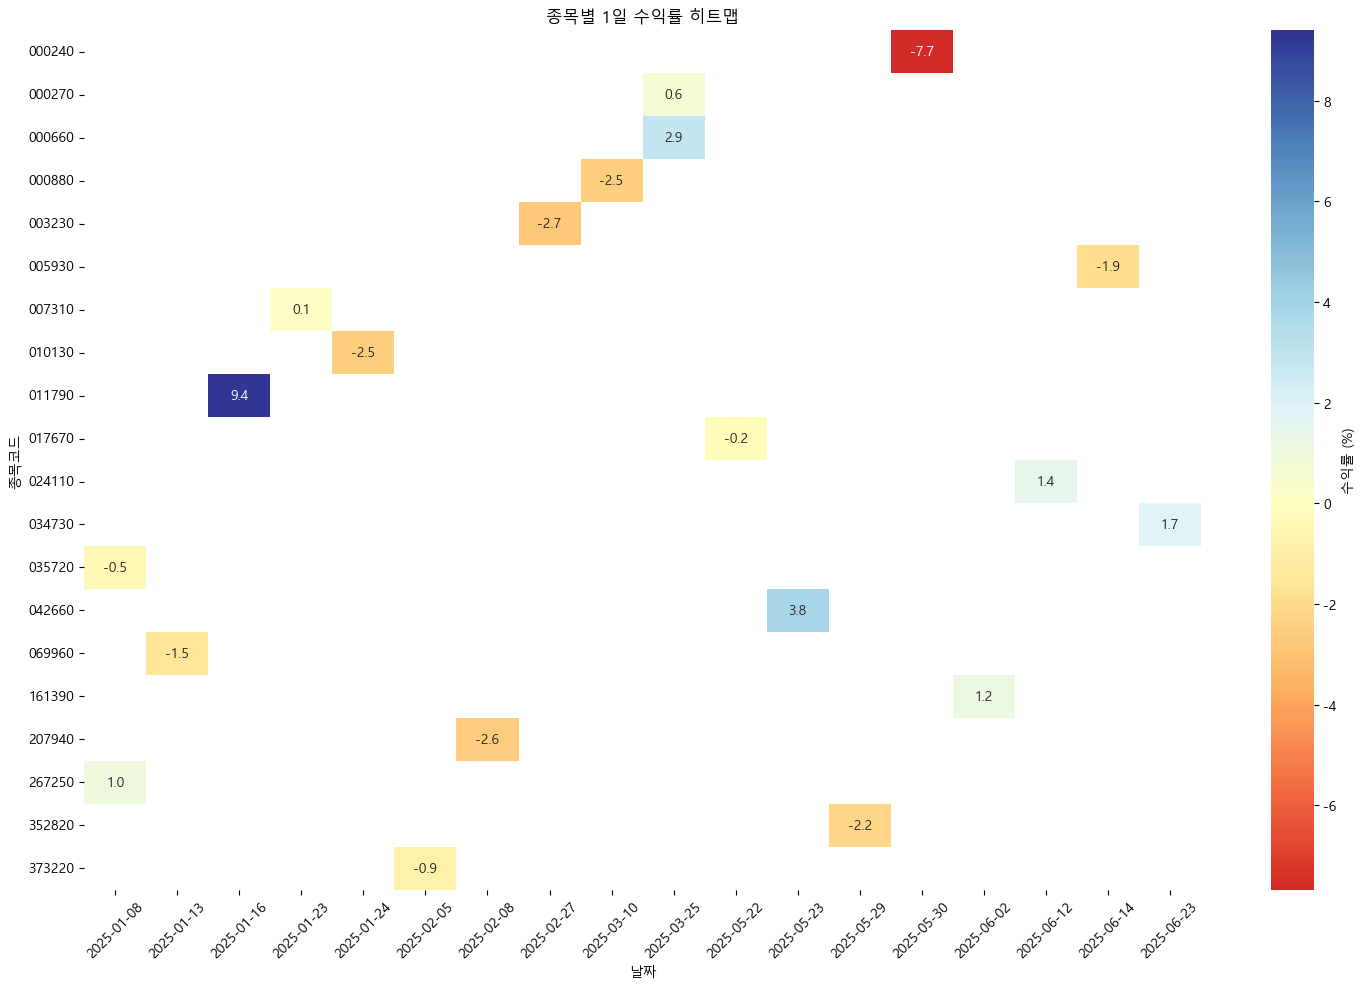

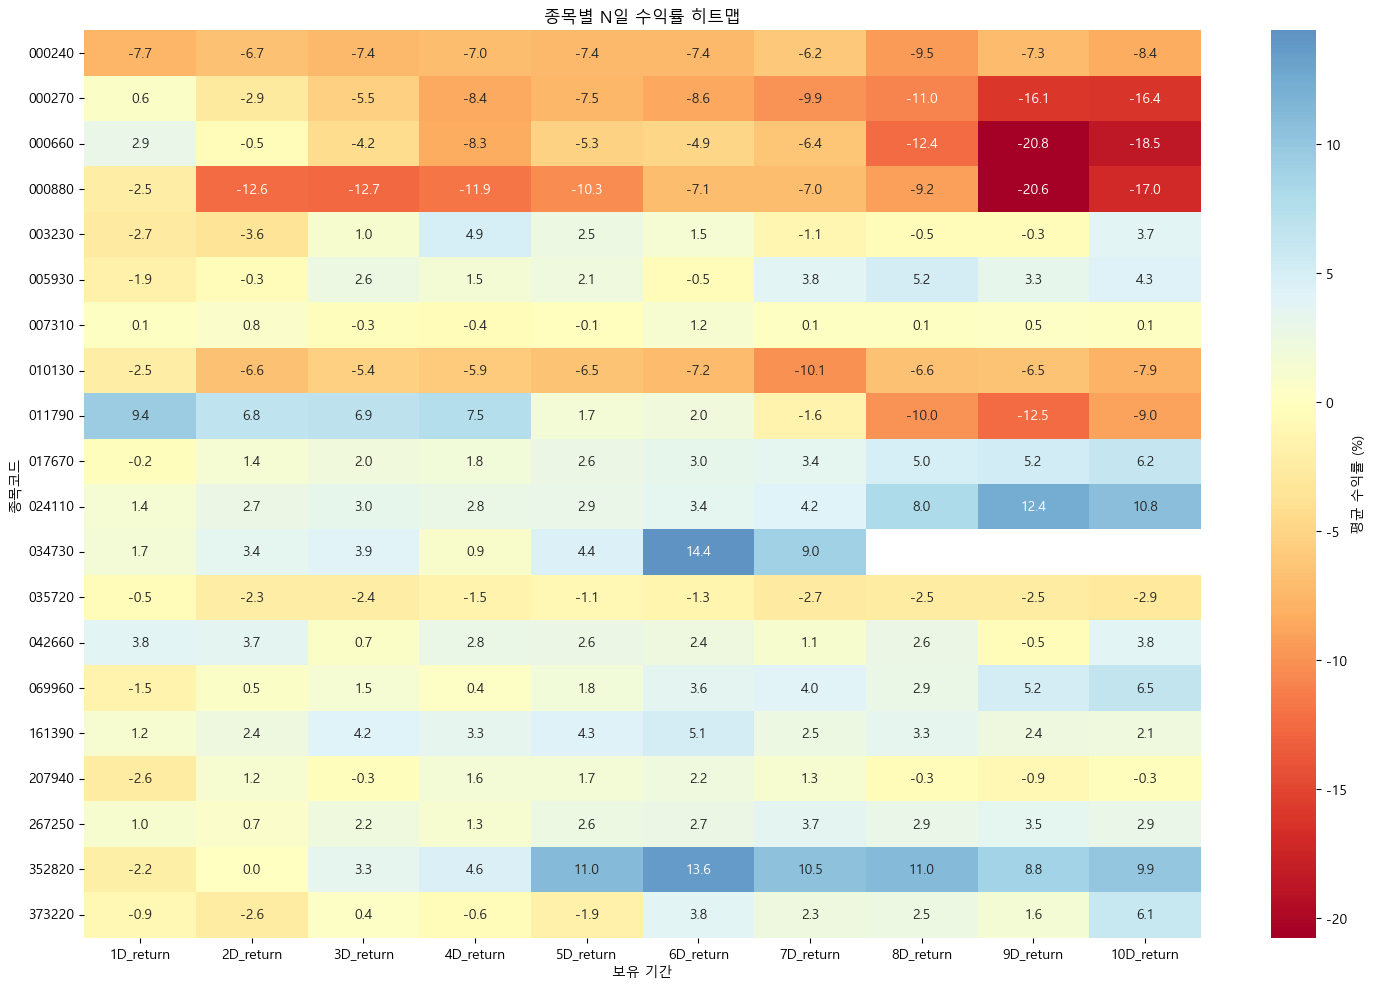

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


# 중복된 인덱스를 처리하기 위해 마지막 값만 사용
pivot_df = returns_df.pivot_table(
    index='stock_code', 
    columns='date',
    values='1D_return',  # 1일 수익률만 사용
    aggfunc='last'  # 중복된 경우 마지막 값 사용
)

# 히트맵 그리기
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap='RdYlBu', center=0, annot=True, fmt='.1f',
            cbar_kws={'label': '수익률 (%)'})

plt.title('종목별 1일 수익률 히트맵')
plt.xlabel('날짜')
plt.ylabel('종목코드')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('heatmap1.png', dpi=300, bbox_inches='tight')
plt.show()

# 기간별(1D~10D) 수익률 히트맵 - 중복 제거 후 평균 계산
period_returns = returns_df.groupby('stock_code')[[f"{i}D_return" for i in range(1,11)]].mean()

plt.figure(figsize=(15, 10))  # 크기를 (15, 10)으로 변경
sns.heatmap(period_returns, cmap='RdYlBu', center=0, annot=True, fmt='.1f',
            cbar_kws={'label': '평균 수익률 (%)'})

plt.title('종목별 N일 수익률 히트맵')
plt.xlabel('보유 기간')
plt.ylabel('종목코드')
plt.tight_layout()
plt.savefig('heatmap2.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
# 기본 통계 확인
print("기본 통계:")
print(returns_df.describe())

# 각 기간별 수익률의 평균
print("\n기간별 평균 수익률:")
mean_returns = returns_df[[f"{i}D_return" for i in range(1,11)]].mean()
print(mean_returns)

# 각 기간별 수익률의 표준편차
print("\n기간별 수익률 표준편차:")
std_returns = returns_df[[f"{i}D_return" for i in range(1,11)]].std()
print(std_returns)

# 양수 수익률의 비율
print("\n양수 수익률 비율:")
positive_returns = returns_df[[f"{i}D_return" for i in range(1,11)]].gt(0).mean() * 100
print(positive_returns.round(2))


기본 통계:
       1D_return  2D_return  3D_return  4D_return  5D_return  6D_return  \
count  20.000000  20.000000  20.000000  20.000000   20.00000   20.00000   
mean   -0.148500  -0.724000  -0.320000  -0.538000    0.00550    1.08850   
std     3.370115   4.353884   4.686565   5.139837    5.13747    6.17586   
min    -7.680000 -12.620000 -12.720000 -11.950000  -10.33000   -8.63000   
25%    -2.280000  -2.677500  -2.852500  -2.582500   -2.73250   -2.22000   
50%    -0.365000   0.265000   0.840000   1.130000    1.76000    2.08500   
75%     1.245000   1.625000   2.690000   2.752500    2.63000    3.45500   
max     9.400000   6.830000   6.900000   7.460000   11.03000   14.40000   

       7D_return  8D_return  9D_return  10D_return  
count  20.000000  19.000000  19.000000   19.000000  
mean    0.044000  -0.975789  -2.376316   -1.252632  
std     5.702176   6.912453   9.370297    9.085707  
min   -10.060000 -12.400000 -20.770000  -18.510000  
25%    -3.542500  -7.905000  -6.900000   -8.150000  

In [41]:
import requests

# DART API 요청
url = 'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key=4f0b54646a8fe705b6294c45880b6448150e55bd'

# GET 요청 보내기 (binary 데이터로 받기)
response = requests.get(url)

# 응답이 성공적인지 확인
if response.status_code == 200:
    # 바이너리 데이터를 파일로 저장
    with open('corpCode.zip', 'wb') as f:
        f.write(response.content)
    print('기업코드 파일이 성공적으로 다운로드되었습니다.')
else:
    print(f'다운로드 실패. 상태 코드: {response.status_code}')


기업코드 파일이 성공적으로 다운로드되었습니다.


In [42]:
import xml.etree.ElementTree as ET
import json

# XML 파일 파싱
tree = ET.parse('corpCode/CORPCODE.xml')
root = tree.getroot()

# XML을 JSON 형식으로 변환
corp_data = []
for corp in root.findall('list'):
    corp_dict = {}
    for elem in corp:
        corp_dict[elem.tag] = elem.text.strip() if elem.text else ''
    corp_data.append(corp_dict)

# JSON 파일로 저장
with open('corpCode/CORPCODE.json', 'w', encoding='utf-8') as f:
    json.dump(corp_data, f, ensure_ascii=False, indent=4)

print('XML 파일이 JSON으로 성공적으로 변환되었습니다.')


XML 파일이 JSON으로 성공적으로 변환되었습니다.


In [ ]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    query = """ 
    WITH new_companies AS (
        SELECT DISTINCT corp_code, corp_name, stock_code
        FROM json_populate_recordset(null::record, 
            (SELECT json_array_elements_text('corpCode/CORPCODE.json'::json))
        ) AS t(corp_code text, corp_name text, corp_eng_name text, stock_code text, modify_date text)
        WHERE stock_code != ''
    )
    INSERT INTO companies (corp_code, company_name, stock_code)
    SELECT corp_code, corp_name, stock_code 
    FROM new_companies n
    WHERE NOT EXISTS (
        SELECT 1 FROM companies c 
        WHERE c.stock_code = n.stock_code
    );
    """
    cursor.execute(query)
    result = cursor.fetchall()
    print("Current Time:", result)

    # Close the cursor and connection
    cursor.close()
    connection.close()
    print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")